In [69]:
import os
import biom
import warnings
import numpy as np
import pandas as pd
from scipy.linalg import norm
from qiime2 import Artifact
from qiime2 import Metadata
from scipy.sparse.linalg import svds
from skbio import OrdinationResults
from skbio.stats.distance import permanova
from skbio.stats.distance import DistanceMatrix
from qiime2.plugins.gemelli.actions import ctf
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.diversity.actions import beta_group_significance
warnings.filterwarnings("ignore", category=DeprecationWarning)

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

plt.style.use('ggplot')
%matplotlib inline

In [2]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

In [3]:
def temporal_plot(x_axis, y_axis, df, ax, title, x_label, y_label,
                  title_fontsize, x_fontsize, y_fontsize, hue=None,
                  style=None, size=None, min_x = 0, max_x = 35, err_style='band', 
                  ci=95, cmap='tab10'):

    """

    This wrapper creates beautiful timeseries plots using
    seaborn and matplotlib. 

    Parameters
    ----------
    x_axis : str, required
        X-axis catagory in dataframe -- data
        
    y_axis : str, required
        y-axis catagory in dataframe -- data
        
    df : dataframe, required
        dataframe of data to plot
    
    ax : matplotlib figure object, required
        panel object from matplotlib figure 
    
    title : str, required
        panel title
    
    x_label : str, required
        x label panel title
    
    y_label : str, required
        y label panel title
        
    title_fontsize : int, required
    x_fontsize : int, required
    y_fontsize : int, required
        font sizes 
    
    hue : str, optional
        color by catagory in dataframe -- data
        
    style : str, optional
        style by catagory in dataframe -- data
    
    Returns
    ----------
    matplotlib figure object

    """
    

    # Lineplot across time 
    sns.lineplot(x=x_axis,
                 y=y_axis,
                 hue=hue,
                 style=style,
                 dashes=True,
                 ci=ci,
                 sort=True,
                 markers=True,
                 estimator=np.mean,
                 err_style=err_style,
                 palette=cmap,
                 data=df,
                 ax=ax)
    
    
    
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(x_label, color='#000000',
                  fontsize=x_fontsize)
    ax.set_ylabel(y_label, color='#000000',
                  fontsize=y_fontsize, labelpad=0)
    
    # remove all grids, backrounds etc ...
    ax.legend_.remove()        
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_bounds(min_x, max_x)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    return ax

# biplot

In [4]:
# metadata
mf = pd.read_csv('../../data/Halfvarson-IBD-Qiita-1629/metadata-matched.tsv', sep='\t', index_col=0)
mf = mf[mf.timepoint <= 7] # remove t=8 (not many samples)
mf_biplot = pd.DataFrame({k:v for k,v in zip(mf.host_subject_id,
                                             mf.IBD)},
                         ['IBD']).T
biplot_import = Artifact.load('../../data/Halfvarson-IBD-Qiita-1629/subject-biplot.qza')
biplot_import = biplot_import.view(OrdinationResults)
# axa
taxonomy = Artifact.load('../../data/Halfvarson-IBD-Qiita-1629/taxonomy.qza').view(pd.DataFrame)
taxonomy.loc[[x for x, y in zip(taxonomy.index,
                                taxonomy.Taxon)
              if len(y.split(';')) > 3], :]


# sort bitplot mag.
V = biplot_import.features.loc[taxonomy.index,
                               [0,1]].dropna().copy()
V['mag'] = norm(abs(V[[0,1]]) , axis=1)
V = V.sort_values(0,ascending=False,)
# add metadata to samples
U = pd.concat([biplot_import.samples,
               mf_biplot],
              axis=1, sort=True)

# add arrow color
n_features = 2
colors = ['#e41a1c', '#377eb8',
          '#4daf4a', '#984ea3',
          '#ff7f00']

subset_feat = list(V.index[:n_features//2]) + list(V.index[-n_features//2:])
#subset_feat = V.index[:n_features]
taxonomy_plot = taxonomy.loc[subset_feat, :]
taxonomy_plot['saved_taxon'] = taxonomy_plot['Taxon']
taxonomy_plot['Taxon'] = [[y.split('__')[1] + ' (' +  y.split('__')[0] + ')'
                           for y in x.split('; ')[::-1] if len(y)>3][2]
                          for x in taxonomy_plot['Taxon'].values]
tax_cmap = {v:col for col,v in zip(colors,set(taxonomy_plot.Taxon))}
tax_cmap_order = [tax_cmap[taxonomy_plot.loc[seq,'Taxon']] 
                  for seq in subset_feat][::-1]
tax_cmap_order


/Users/cmartino/miniconda3/envs/qiime2-2019.10-tut/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 

Passing list-likes to .loc or [] with any missing label will raise

KeyError in the future, you can use .reindex() as an alternative.



See the documentation here:

https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike

  return self._getitem_tuple(key)


['#377eb8', '#e41a1c']

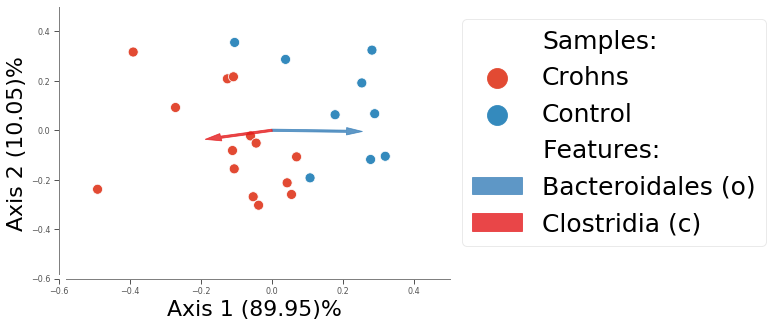

In [5]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

def biplot(score, coeff, pcax, pcay, ax, tax_cmap_order,
           colorby='IBD', n_features=3):
    n=score.shape[1]
    sns.scatterplot(x=pcax, y=pcay, hue='IBD', data=score, ax=ax)
    annots = []
    seqs = []
    for i in range(n_features):
        annots.append(ax.arrow(0, 0,
                               coeff.iloc[i,pcay] * 1.8,
                               coeff.iloc[i,pcax] * 1.8,
                               color=tax_cmap_order[i],
                               alpha=0.8,
                               length_includes_head=True,
                               head_width=.03, width=.009))
        seqs.append(coeff.index[i])
    ax.set_xlabel("PC{}".format(pcax+1))
    ax.set_ylabel("PC{}".format(pcay+1))
    return annots, seqs
    
fig, ax = plt.subplots(1,1,figsize=(7,5))

axis1 = 0
axis2 = 1

axis1_label = 'Axis %i (%.2f)%%'%(axis1+1,
                                  (biplot_import.proportion_explained[axis1] - .1) * 100)
axis2_label = 'Axis %i (%.2f)%%'%(axis2+1,
                                  (biplot_import.proportion_explained[axis2] + .1) * 100)

annots, seqs = biplot(U, V.loc[taxonomy_plot.index,:],
                      axis2, axis1, ax,
                      tax_cmap_order, n_features=n_features)

ax.set_xlabel(axis1_label, fontsize=22, color='black')
ax.set_ylabel(axis2_label, fontsize=22, color='black')
ax.set_ylim(-.6,.5)
ax.set_xlim(-.6,.5)

# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend([handles[0]] + handles[1:] \
                   + [handles[0]] + annots,
                   ['Samples:'] + labels[1:] + \
                   ['Features:'] + \
                   [taxonomy_plot.loc[seq,'Taxon'] for seq in seqs], 
                   loc=2, 
                         bbox_to_anchor=(1.0, 1.0),
                         prop={'size':25},
                         fancybox=True, framealpha=0.5, 
                         ncol=1, markerscale=2, facecolor="white")

# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)

# remove all grids, backrounds etc ...
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_bounds(-.58,.5)
ax.spines['bottom'].set_bounds(-.58,.5)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)
# save the figure to file
plt.savefig('../../results/example-workflow-biplot.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()


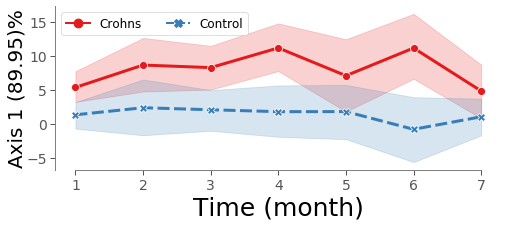

In [6]:
sub_trajectory = Artifact.load('../../data/Halfvarson-IBD-Qiita-1629/state-subject-ordination.qza')
sub_trajectory = sub_trajectory.view(Metadata).to_dataframe()

# set label font-sizes globally
paper_rc = {'lines.linewidth': 3, 
            'lines.markersize': 8}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 14 
plt.rcParams['ytick.labelsize'] = 14

fig, ax = plt.subplots(1,1,figsize=(8, 3))

# plot labels
y_label = axis1_label
x_label = 'Time (month)' 
title = ''

ax = temporal_plot('timepoint','PC1',
                   sub_trajectory.sort_values('IBD',ascending=False), ax,
                    title, x_label, y_label, 35, 25, 20,
                    hue='IBD', style='IBD', ci=68,
                    min_x=1, max_x=7, cmap='Set1')
#ax.set_xlim(.9,7)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:],
            prop={'size':12}, loc=2, 
            bbox_to_anchor=(0.00, 1.),
            fancybox=True, framealpha=0.8,ncol=2
            , markerscale=1.1, facecolor="white")

# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)

# save the figure to file
plt.savefig('../../results/example-workflow-traj-sub.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
           edgecolor='none')

plt.show()


# feature trajectory

In [7]:
btdf = biom.load_table('../../data/Halfvarson-IBD-Qiita-1629/table-matched.biom').to_dataframe()
feature_trajectory = Artifact.load('../../data/Halfvarson-IBD-Qiita-1629/state-feature-ordination.qza')
feature_trajectory = feature_trajectory.view(pd.DataFrame)
taxonomy = Artifact.load('../../data/Halfvarson-IBD-Qiita-1629/taxonomy.qza').view(pd.DataFrame)
tax_dict = dict(taxonomy['Taxon'])
feature_trajectory['Taxon'] = [tax_dict[v] for v in feature_trajectory.feature_id]

feat_map = dict(taxonomy.Taxon)
feature_trajectory['Taxon'] = [feat_map[feat]
                               if feat in feat_map.keys()
                               else np.nan
                               for feat in feature_trajectory.feature_id]
# add taxonomic levels for grouping later (if available)

def tax_split(tax_id, tax_level): return tax_id.split(tax_level)[1].split(';')[0]

for level, lname in zip(['k__', 'p__', 'c__', 'o__',
                         'f__', 'g__', 's__'],
                        ['kingdom', 'phylum', 'class',
                         'order', 'family', 'genus',
                         'species']):
    if lname not in taxonomy.columns:
        taxonomy_tmp = []
        for tax in feature_trajectory.Taxon:
            if tax is not np.nan and\
               level in tax and\
               len(tax_split(tax, level)) > 0:
                taxonomy_tmp.append(tax_split(tax,
                                              level))
            else:
                taxonomy_tmp.append(np.nan)
        feature_trajectory[lname] = taxonomy_tmp
feature_trajectory = feature_trajectory.reset_index()
feature_trajectory['featureid'] = feature_trajectory['featureid'].values.astype(int)
feature_trajectory.head(5)

/Users/cmartino/miniconda3/envs/qiime2-2019.10-tut/lib/python3.6/site-packages/biom/table.py:4049: FutureWarning: SparseSeries is deprecated and will be removed in a future version.

Use a Series with sparse values instead.



    >>> series = pd.Series(pd.SparseArray(...))



See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.



  for r in self.matrix_data.tocsr()]

/Users/cmartino/miniconda3/envs/qiime2-2019.10-tut/lib/python3.6/site-packages/biom/table.py:4052: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.

Use a regular DataFrame whose columns are SparseArrays instead.



See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.



  return constructor(mat, index=index, columns=columns)


,featureid,PC1,PC2,PC3,PC4,feature_id,timepoint,Taxon,kingdom,phylum,class,order,family,genus,species
0,0,0.005768,-0.004212,-0.007153,-0.002938,ACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCAC...,1.0,k__Bacteria; p__Proteobacteria; c__Gammaproteo...,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,NaN,NaN
1,1,0.010570,-0.003613,-0.006646,-0.001921,ACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCAC...,2.0,k__Bacteria; p__Proteobacteria; c__Gammaproteo...,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,NaN,NaN
2,2,0.009060,-0.004109,-0.007336,-0.003421,ACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCAC...,3.0,k__Bacteria; p__Proteobacteria; c__Gammaproteo...,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,NaN,NaN
3,3,0.010368,-0.003533,-0.006384,-0.001440,ACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCAC...,4.0,k__Bacteria; p__Proteobacteria; c__Gammaproteo...,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,NaN,NaN
4,4,0.010422,-0.003697,-0.006829,-0.002119,ACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCAC...,5.0,k__Bacteria; p__Proteobacteria; c__Gammaproteo...,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,NaN,NaN


In [8]:
feature_trajectory_plot = feature_trajectory.groupby('feature_id').mean().copy()
pc1_sts = feature_trajectory_plot.PC1.describe()
feature_trajectory_plot = feature_trajectory_plot.sort_values('PC1').reset_index()
feature_trajectory_plot['featureid'] = feature_trajectory_plot['featureid'].values.astype(float)

print(feature_trajectory_plot.shape)
feature_trajectory_plot.head(3)


(3087, 7)


,feature_id,featureid,PC1,PC2,PC3,PC4,timepoint
0,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGC...,19631.0,-0.814516,-0.006353,0.000033,0.010822,4.0
1,ACGTAGGTGGCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGTGC...,11315.0,-0.777137,-0.026347,0.008272,0.016885,4.0
2,ACGTAGGGAGCGAGCGTTGTCCGGAATTACTGGGTGTAAGGGTGCG...,19694.0,-0.747596,-0.064050,0.008718,0.017797,4.0


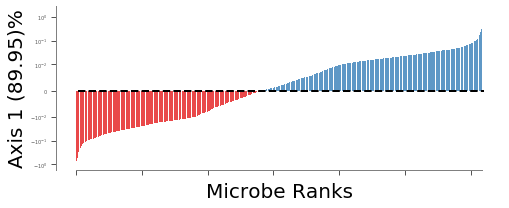

In [9]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 8}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 5


fig, axn = plt.subplots(1,1, figsize=(8, 3))

# bar plot of ranks (upper and low quartile)
axis1_label = 'Axis 1 (%.2f)%%'% ((biplot_import.proportion_explained[axis1] - .1) * 100)
feature_trajectory_plot = feature_trajectory_plot.sort_values('PC1')
c_ = ['#e41a1c' if v < 0 else '#377eb8' for v in feature_trajectory_plot.PC1]
axn.bar(feature_trajectory_plot.index,
        feature_trajectory_plot.PC1,
        color=c_, alpha=.8)

# tick labels
axn.set_xticklabels([])
axn.set_ylabel(axis1_label,
               fontsize=20,
               color='black')
axn.set_xlabel('Microbe Ranks',
               fontsize=20,
               color='black')

# scale axis
axn.set_yscale('symlog', linthreshy=.01)

# remove all grids, backrounds etc ...
axn.set_facecolor('white')
axn.set_axisbelow(True)
axn.spines['right'].set_visible(False)
axn.spines['left'].set_visible(True)
axn.spines['bottom'].set_visible(True)
axn.spines['top'].set_visible(False)
axn.spines['bottom'].set_bounds(0, feature_trajectory_plot.shape[0])
for child in axn.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')
# line
axn.axhline(0, xmin=0.05, xmax=.96,
            ls='--', lw=2, c='black')        
plt.savefig('../../results/example-workflow-ranks.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()



## log-ratio

/Users/cmartino/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/generic.py:5997: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.

Use a regular DataFrame whose columns are SparseArrays instead.



See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.



  return self._constructor(data).__finalize__(self)

/Users/cmartino/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.

Use a Series with sparse values instead.



    >>> series = pd.Series(pd.SparseArray(...))



See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.



  return klass(values, index=self.index, name=items, fastpath=True)

/Users/cmartino/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/sparse/frame.py:785: FutureWarning: SparseDataFrame is deprecate

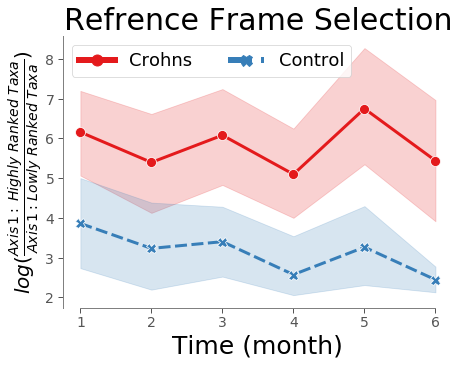

In [12]:

pc = 'mag'
lr = []
btdfps = btdf.copy()
feature_trajectory['mag'] = norm(feature_trajectory[['PC1','PC2']], axis=1)

for month_,mdf  in feature_trajectory.groupby('timepoint'):
    mdf = mdf.set_index('feature_id')
    mdf = mdf.sort_values(pc)
    subids = mf[mf.timepoint.isin([int(month_)])].index
    num_ind = mdf['PC1'][:950].index
    den_ind = mdf['PC1'][-950:].index     
    num = np.log(btdfps.loc[num_ind,subids].sum(axis=0))
    den = np.log(btdfps.loc[den_ind,subids].sum(axis=0))
    lr_sub = pd.DataFrame(num - den,columns=['logratio'])
    lr.append(lr_sub)

lr = pd.concat(lr)
lr = pd.concat([lr,mf], axis=1, sort=True)
lr = lr[lr.timepoint < 7]
lr['logratio'][~np.isfinite(lr['logratio'])] = np.nan
lr = lr.dropna(subset=['logratio'])

# set label font-sizes globally
paper_rc = {'lines.linewidth': 3, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 14 
plt.rcParams['ytick.labelsize'] = 14

fig, ax = plt.subplots(1,1,figsize=(7,5))

# plot labels
y_label = '$log(\\frac{Axis\,1:\,\,Highly\,\,Ranked\,\,Taxa}{Axis\,1:\,Lowly\,\,Ranked\,\,Taxa})$'
x_label = 'Time (month)' 
title = ''

ax = temporal_plot('timepoint','logratio',
                   lr.sort_values('IBD',ascending=False), ax,
                    title, x_label, y_label, 35, 25, 20,
                    hue='IBD', style='IBD', ci=68,
                    min_x=1, max_x=6, cmap='Set1')
#ax.set_xlim(.9,7)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:],
            prop={'size':18}, loc=2, 
            bbox_to_anchor=(0.00, 1.),
            fancybox=True, framealpha=0.8,ncol=2
            , markerscale=1.1, facecolor="white")

# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(6.0)

ax.set_title('Refrence Frame Selection', fontsize=30)

# save the figure to file
plt.savefig('../../results/example-workflow-log-ratios.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
           edgecolor='none')

plt.show()

## permanova

In [14]:
dists = {dist:Artifact.load(os.path.join('../../data/Halfvarson-IBD-Qiita-1629/subsampled-time',
                                         dist)).view(DistanceMatrix)
         for dist in os.listdir('../../data/Halfvarson-IBD-Qiita-1629/subsampled-time') 
         if 'distance' in dist}

mfs = {mf_.split('-')[0]:pd.read_csv(os.path.join('../../data/Halfvarson-IBD-Qiita-1629/subsampled-time',mf_),
                                     sep='\t', index_col=0)
         for mf_ in os.listdir('../../data/Halfvarson-IBD-Qiita-1629/subsampled-time')
       if 'metadata' in mf_}

perms = pd.concat({method_:pd.DataFrame(permanova(dist_, mfs[method_.split('-')[0]], 'IBD')) 
               for method_,dist_ in dists.items()}).reset_index()
perms.columns = ['method', 'type','PERMANOVA']
perms['N-timepoints'] = [int(v.split('-')[0]) for v in perms['method']]
perms['method'] = [v.split('-')[1] for v in perms['method']]
renamed = {'aitchison':'Aitchison', 
           'braycurtis':'Bray-Curtis', 
           'distance':'CTF', 
           'jaccard':'Jaccard', 
           'unifrac':'UniFrac', 
           'wunifrac':'W-UniFrac'}
cmap_methods = {'Aitchison':'#377eb8', 
                'Bray-Curtis':'#ff7f00', 
                'CTF':'#4daf4a', 
                'Jaccard':'#999999', 
                'UniFrac':'#984ea3', 
                'W-UniFrac':'#e41a1c'}
perms = perms.replace(renamed)
perms = perms[perms['N-timepoints'] < 7]
perms.to_csv('../../results/example-workflow-halfvarson-permanova.tsv',
             sep='\t')
perms.head(5)


,method,type,PERMANOVA,N-timepoints
0,W-UniFrac,method name,PERMANOVA,5
1,W-UniFrac,test statistic name,pseudo-F,5
2,W-UniFrac,sample size,101,5
3,W-UniFrac,number of groups,2,5
4,W-UniFrac,test statistic,3.0086,5


In [15]:
perm_tst = perms.rename({'N-timepoints':'timepoints'},axis=1)[perms['N-timepoints'] > 1]
fbymthd = {method_:resdf_[resdf_.type.isin(['test statistic'])].set_index('timepoints') 
           for method_, resdf_ in perm_tst.groupby(['method'])}

fchperm = pd.DataFrame({k:["%.2f ± %.2f"%(np.mean(fbymthd['CTF'].loc[df.index, :].PERMANOVA.values/df.PERMANOVA.values),
                                 np.std(fbymthd['CTF'].loc[df.index, :].PERMANOVA.values/df.PERMANOVA.values))]
              for k,df in fbymthd.items()},['Fold-Change']).T.sort_index()
fchperm.to_csv('../../results/example-workflow-halfvarson-permanova-fold-change.tsv',
               sep='\t')
fchperm


,Fold-Change
Aitchison,4.86 ± 2.67
Bray-Curtis,6.81 ± 4.05
CTF,1.00 ± 0.00
Jaccard,6.62 ± 4.27
UniFrac,3.55 ± 2.30
W-UniFrac,9.44 ± 5.77


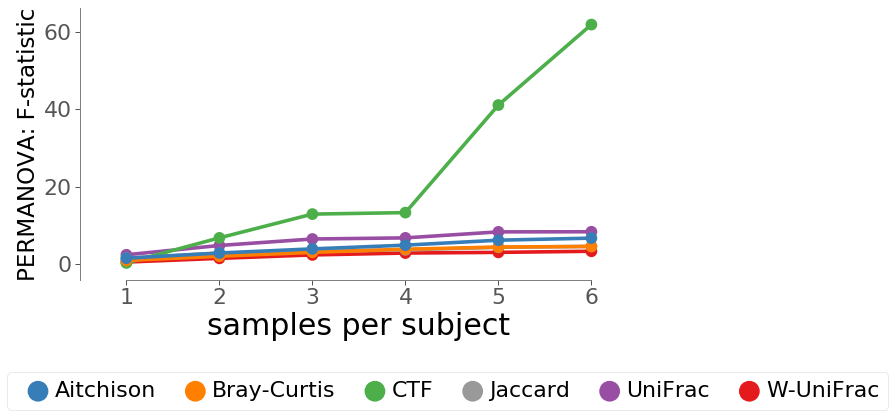

In [16]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 22 
plt.rcParams['ytick.labelsize'] = 22

fig, ax = plt.subplots(1,1, figsize=(10,5))


perms_plot = perms[perms.type.isin(['test statistic'])]
sns.pointplot(x='N-timepoints', y='PERMANOVA', hue='method',style='method',
              data=perms_plot[perms_plot['N-timepoints'] < 7].sort_values('method',ascending=False),
              ax=ax, palette=cmap_methods)

ax.set_ylabel('PERMANOVA: F-statistic', fontsize=23, color='black')
ax.set_xlabel('samples per subject', fontsize=30, color='black')
#ax.axhline(.5, lw=2, ls='--', c='#e41a1c')
#ax.set_ylim(0.4,1.01)

# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labels[::-1], loc=2, 
                         bbox_to_anchor=(-0.15, -.30),
                         prop={'size':22}, handletextpad=-0.25,
                         fancybox=True, framealpha=0.5, columnspacing=.8,
                         ncol=6, markerscale=2, facecolor="white")
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)

# remove all grids, backrounds etc ...
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_bounds(0, 5)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# save the figure to file
plt.savefig('../../results/example-workflow-halfvarson-PERMANOVA.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.show()



# KNN-classification


In [17]:
from inspect import signature
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score


In [19]:
ords = {dist:pd.concat([Artifact.load(os.path.join('../../data/Halfvarson-IBD-Qiita-1629/subsampled-time',
                                                   dist)).view(OrdinationResults).samples,
                        mfs[dist.split('-')[0]]], axis=1, sort=True).groupby('host_subject_id').sum()
         for dist in os.listdir('../../data/Halfvarson-IBD-Qiita-1629/subsampled-time') if 'pcoa' in dist}
ords = {k:ord_.loc[:, set(list(range(200))) & set(ord_.columns)] 
        for k,ord_ in ords.items()}

biplots = {dist:Artifact.load(os.path.join('../../data/Halfvarson-IBD-Qiita-1629/subsampled-time',dist)).view(OrdinationResults).samples[[0,1]]
           for dist in os.listdir('../../data/Halfvarson-IBD-Qiita-1629/subsampled-time')
           if 'subject-biplot' in dist}

ords = {**ords,**biplots}

ibd_map = {t_:pd.DataFrame({k:[v] for k,v in zip(mf_.host_subject_id,mf_.IBD)},
                           ['IBD']).T 
           for t_,mf_ in mfs.items()}

ord_time = {}
for t_ in ibd_map.keys():
    ord_time_ = {}
    for method, ord_ in ords.items():
        if method.split('-')[0] == t_:
            ord_time_[method] = ord_
    ord_time[t_] = ord_time_

# run KNN    
res = {}
for t_, mf_ in ibd_map.items():
    ord_learn = ord_time[t_]
    for method, ord_ in ord_learn.items():
        
        
        X = ord_.values
        y = mf_.loc[ord_.index, 'IBD']

        le = preprocessing.LabelEncoder()
        le.fit(y)
        y = le.transform(y) 
        
        scoring_ = {'APR':'average_precision',
                    'AUC':'roc_auc'}
        
        for scoring_method, scoring_ in scoring_.items():

            # instantiate the grid
            k_range = list(range(3, 15))
            param_grid = dict(n_neighbors=k_range)
            classifier = KNeighborsClassifier()
            grid = GridSearchCV(classifier, param_grid, cv=5,
                                scoring=scoring_)
            grid.fit(X, y)
            classifier = grid.best_estimator_

            for i, score_ in enumerate(grid.cv_results_['mean_test_score']):
                res[(int(t_),method.split('-')[1],scoring_method, i)] = [score_]

renamed = {'aitchison':'Aitchison', 
           'braycurtis':'Bray-Curtis', 
           'subject':'CTF', 
           'jaccard':'Jaccard', 
           'unifrac':'UniFrac', 
           'wunifrac':'W-UniFrac'}
knnres = pd.DataFrame(res).T.reset_index()
knnres.columns = ['N-timepoints','Method',
                  'Scoring-Method','Fold',
                  'Score']
knnres = knnres.replace(renamed)
knnres[knnres['N-timepoints'] < 7]
knnres.to_csv('../../results/example-workflow-halfvarson-KNN.tsv',
              sep='\t')
knnres.head(5)

,N-timepoints,Method,Scoring-Method,Fold,Score
0,1,Jaccard,APR,0,0.750000
1,1,Jaccard,APR,1,0.772222
2,1,Jaccard,APR,2,0.816667
3,1,Jaccard,APR,3,0.816667
4,1,Jaccard,APR,4,0.795833


In [20]:
perm_tst = knnres.rename({'N-timepoints':'timepoints'},axis=1)[knnres['N-timepoints'] > 1]
fbymthd = {(smethod_, method_):resdf_.groupby('timepoints').mean()
           for (smethod_, method_), resdf_ in perm_tst.groupby(['Scoring-Method','Method'])}

fchknn = pd.DataFrame({k:["%.2f ± %.2f"%(np.mean(fbymthd[(k[0], 'CTF')].loc[df.index, :].Score.values - df.Score.values)*100,
                                 np.std(fbymthd[(k[0], 'CTF')].loc[df.index, :].Score.values - df.Score.values)*100)]
              for k,df in fbymthd.items()},['Fold-Change']).T.sort_index()
fchknn.to_csv('../../results/example-workflow-halfvarson-KNN-fold-change.tsv',
               sep='\t')
fchknn


Fold-Change

APR Aitchison    16.48 ± 2.10

    Bray-Curtis  18.75 ± 2.92

    CTF           0.00 ± 0.00

    Jaccard      14.06 ± 2.82

    UniFrac      10.00 ± 1.89

    W-UniFrac    23.30 ± 2.29

AUC Aitchison    20.67 ± 3.45

    Bray-Curtis  27.29 ± 5.23

    CTF           0.00 ± 0.00

    Jaccard      19.08 ± 4.12

    UniFrac      15.20 ± 3.27

    W-UniFrac    35.34 ± 3.50

/Users/cmartino/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  # This is added back by InteractiveShellApp.init_path()


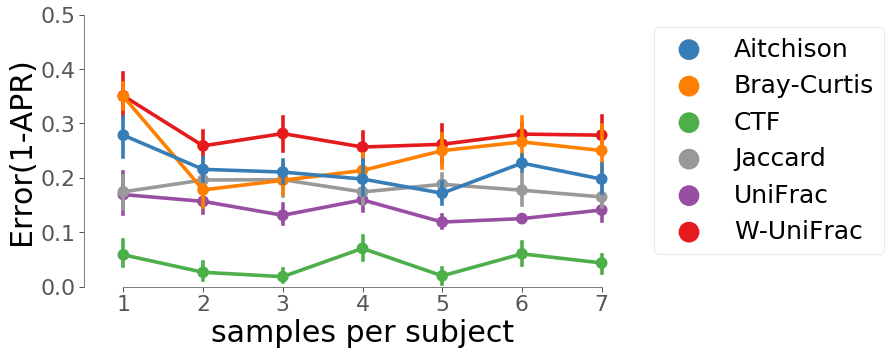

/Users/cmartino/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  # This is added back by InteractiveShellApp.init_path()


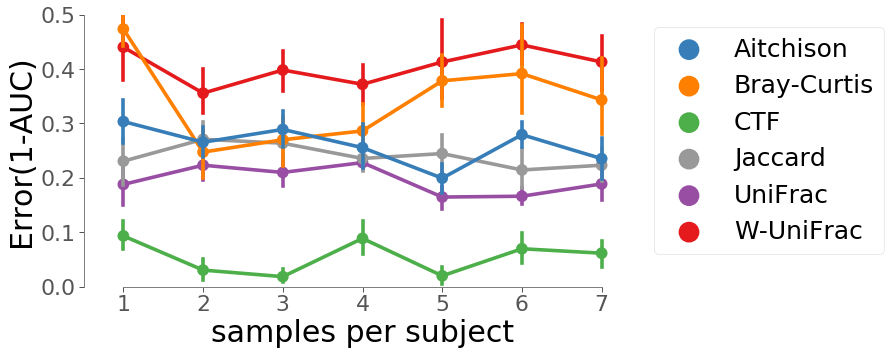

In [21]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 22 
plt.rcParams['ytick.labelsize'] = 22

for y_score, df_plot in knnres.groupby('Scoring-Method'):

    fig, ax = plt.subplots(1,1, figsize=(10,5))
    df_plot['error'] = (1.00 - df_plot['Score'])

    sns.pointplot(x='N-timepoints', y='error', hue='Method',
                  data=df_plot[df_plot['N-timepoints'] <= 7].sort_values('Method', ascending=False),
                  ax=ax, palette=cmap_methods)
    ax.set_ylabel('Error(1-%s)' %y_score, fontsize=30, color='black')
    ax.set_xlabel('samples per subject', fontsize=30, color='black')
    ax.set_ylim(0.0,.5)
    
    
    # generate legend from last iterations     
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[::-1], labels[::-1], loc=2, 
                             bbox_to_anchor=(1.0, 1.0),
                             prop={'size':25},
                             fancybox=True, framealpha=0.5, 
                             ncol=1, markerscale=2, facecolor="white")
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(8.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(4.0)
        
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_bounds(0, 6)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
        
    # set the backrounf to be transparent
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(0.0)

    # save the figure to file
    plt.savefig('../../results/example-workflow-halfvarson-KNN-%s.pdf'%(y_score),dpi=1000, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')

    plt.show()


### taxonomy plot

In [208]:
# import biplot
biplot_import = Artifact.load('../../data/Halfvarson-IBD-Qiita-1629/subject-biplot.qza')
biplot_import = biplot_import.view(OrdinationResults)
feature_trajectory = biplot_import.features
feature_trajectory.columns = ['PC1','PC2','PC3','PC4']
feature_trajectory['feature_id'] = feature_trajectory.index
# import taxonomy
taxonomy = Artifact.load('../../data/Halfvarson-IBD-Qiita-1629/taxonomy.qza').view(pd.DataFrame)
tax_dict = dict(taxonomy['Taxon'])
feature_trajectory['Taxon'] = [tax_dict[v] for v in feature_trajectory.feature_id]
# split taxa
def tax_split(tax_id, tax_level): return tax_id.split(tax_level)[1].split(';')[0]

for level, lname in zip(['k__', 'p__', 'c__', 'o__',
                         'f__', 'g__', 's__'],
                        ['kingdom', 'phylum', 'class',
                         'order', 'family', 'genus',
                         'species']):
    if lname not in taxonomy.columns:
        taxonomy_tmp = []
        for tax in feature_trajectory.Taxon:
            if tax is not np.nan and\
               level in tax and\
               len(tax_split(tax, level)) > 0:
                taxonomy_tmp.append(tax_split(tax,
                                              level))
            else:
                taxonomy_tmp.append(np.nan)
        feature_trajectory[lname] = taxonomy_tmp
# definately mis-classified
#feature_trajectory = feature_trajectory[~feature_trajectory.phylum.isin(['Euryarchaeota',
#                                                                         'Chloroflexi',
#                                                                         'Cyanobacteria'])]    
# filter by number of occurance
fcount = feature_trajectory['phylum'].value_counts()
fcount = fcount[fcount > 40].index
feature_trajectory = feature_trajectory[feature_trajectory['phylum'].isin(fcount)]
feature_trajectory['ranking'] = feature_trajectory['PC1']
feature_trajectory['ASV'] = feature_trajectory.feature_id


/Users/cmartino/miniconda3/envs/qiime2-2019.10-tut/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/cmartino/miniconda3/envs/qiime2-2019.10-tut/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [303]:
level = 'genus'

join_plot_ranks  = feature_trajectory.copy()
join_plot_ranks['label'] = join_plot_ranks[level]
# associations
join_plot_ranks['grouping'] = ['Crohns' if x > 0 else 'Controls'
                                    for x in join_plot_ranks['PC1']]
# add counts
count_ = join_plot_ranks.label.value_counts()
count_ = count_[count_ > 2].index
join_plot_ranks = join_plot_ranks[join_plot_ranks.label.isin(count_)]
# quantile filter
join_plot_ranks_order = join_plot_ranks.groupby('label').sum().sort_values('ranking')
min_, max_ = join_plot_ranks_order.ranking.quantile([0.1,0.9]).values
# get lower index
lower_label = join_plot_ranks_order.loc[(join_plot_ranks_order['ranking'] < min_)].index
join_plot_asv = join_plot_ranks.groupby('ASV').max()
lower_ASV = list(join_plot_asv.loc[(join_plot_asv['ranking'] < 0)].index)
lower_ = join_plot_ranks[((join_plot_ranks.label.isin(lower_label))\
                         & (join_plot_ranks.ASV.isin(lower_ASV)))].index
# get upper index
upper_ = list(join_plot_ranks_order.loc[(join_plot_ranks_order['ranking'] > max_)].index)
join_plot_asv = join_plot_ranks.groupby('ASV').min()
add_ = list(join_plot_ranks_order[join_plot_ranks_order.index == 'Ruminococcus'].index)
upper_ = upper_ + add_
upper_ASV = list(join_plot_asv.loc[(join_plot_asv['ranking'] > 0)].index)
upper_ = join_plot_ranks[((join_plot_ranks.label.isin(upper_))\
                         & (join_plot_ranks.ASV.isin(upper_ASV)))].index
keep_ = sorted(set(list(lower_) + list(upper_)))
join_plot_ranks = join_plot_ranks.loc[keep_, :]
# plot order
order_ = join_plot_ranks.groupby('label').mean().sort_values('ranking').index
order_ = {ord_:i_ for i_, ord_ in enumerate(order_)}
join_plot_ranks['ranking'] *= -1
join_plot_ranks['order'] = [order_[v] for v in join_plot_ranks.label]
join_plot_ranks['label'] = [x.replace(']','').replace('[','') for x in join_plot_ranks.label]


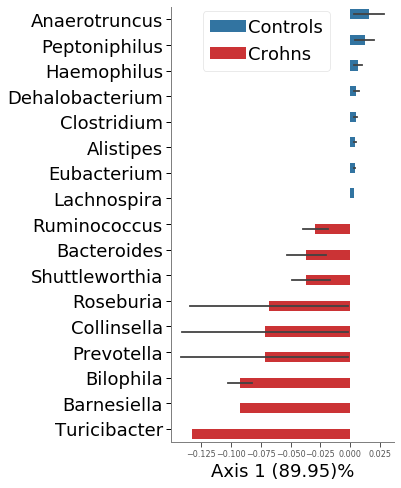

In [305]:
# plot
paper_rc = {'lines.linewidth': 1, 
            'lines.markersize': 1}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 18

pall_ = {'Crohns':'#e41a1c',
         'Controls':'#1f78b4'}

fig, ax = plt.subplots(1,1, figsize=(4, 8))

sns.barplot(x='ranking', y='label', hue='grouping',
            palette=pall_, ci=68,
            data=join_plot_ranks.sort_values('order'),
            ax=ax)

ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels,
                    prop={'size':18}, loc=2, 
                    handletextpad=0.1,
                    bbox_to_anchor=(.10, 1.01),
                    fancybox=True, framealpha=0.1, ncol=1
                    , facecolor="white",
                    edgecolor='black')
ax.set_ylabel('')
axis1_label = 'Axis 1 (%.2f)%%'% ((biplot_import.proportion_explained[axis1] - .1) * 100)
ax.set_xlabel(axis1_label,
              c='black',fontsize=18)
#ax.set_xlabel('Feature Ranking (genus level)',
#              c='black',fontsize=18)
ax.yaxis.label.set_color('black')
ax.tick_params(axis='y', colors='black')
plt.savefig('../../results/example-workflow-ranks-taxonomy.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()